## Validação dos pseudo-neagtivos com Random Forest

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
import numpy
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('dataset_final_para_modelo.csv', decimal=",")
df

,latitude,longitude,data,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.333684,-49.048348,2022-10-21,10,1,0,0.0,0,0,0,0,0,0,0
1,-22.301419,-49.048727,2022-07-30,22,0,0,0.0,0,0,0,0,0,0,0
2,-22.339661,-49.052127,2022-01-20,1,0,1,0.0,0,0,0,0,0,0,0
3,-22.316303,-49.013965,2024-12-07,17,1,0,0.0,0,0,1,0,0,0,1
4,-22.317141,-49.074546,2024-02-04,23,0,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24562,-22.367021,-48.994193,2024-08-11,10,0,1,0.0,0,0,0,0,0,0,0
24563,-22.278111,-49.074664,2025-01-04,23,1,0,0.0,0,0,1,0,1,0,0
24564,-22.228542,-49.229450,2024-12-22,19,0,0,0.0,0,0,0,0,0,0,0
24565,-22.305045,-49.106929,2023-08-20,12,1,0,0.0,0,0,1,0,0,0,0


### Separação de Features (X) e Alvo (y)

In [11]:
X = df.drop(columns=['Sinistro', 'data']) 

y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (17196, 12)
Tamanho do conjunto de teste: (7371, 12)


### Treinar o modelo

In [12]:
model = RandomForestClassifier(
    random_state=8
    )

print("Treinando o modelo Random Forest...")
model.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando o modelo Random Forest...
Treinamento concluído.


### Fazer previsões e avaliar as métricas

In [13]:
# O modelo faz as previsões nos dados de teste
y_pred = model.predict(X_test)

# --- Avaliação ---

print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"--- AUC (Área Sob a Curva ROC) ---")
print(f"{auc:.4f}")


--- Matriz de Confusão ---
[[4493  421]
 [ 872 1585]]

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4914
           1       0.79      0.65      0.71      2457

    accuracy                           0.82      7371
   macro avg       0.81      0.78      0.79      7371
weighted avg       0.82      0.82      0.82      7371

--- AUC (Área Sob a Curva ROC) ---
0.8637


### SHAP (Shapley Additive exPlanations)

In [14]:
explainer = shap.TreeExplainer(model)
print("Calculando valores SHAP")
shap_values = explainer.shap_values(X_test.to_numpy())

# Gráficos de importância

# Adicione estas linhas para diagnóstico
print("--- Diagnóstico SHAP ---")
print(f"Shape do X_test: {X_test.shape}")
print(f"Shape dos SHAP values (classe 1): {shap_values[1].shape}")

print("\nTipos de dados no X_test:")
print(X_test.dtypes)

# Gráfico de barras com foco na classe positiva (1)
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=True)

# Gráfico de Resumo (Beeswarm) com foco na classe positiva (1)
shap.summary_plot(shap_values[1], X_test, show=True)

Calculando valores SHAP
--- Diagnóstico SHAP ---
Shape do X_test: (7371, 12)
Shape dos SHAP values (classe 1): (12, 2)

Tipos de dados no X_test:
latitude                     float64
longitude                    float64
hora                           int64
Chuva                          int64
tipo_via_num                 float64
tp_veiculo_bicicleta           int64
tp_veiculo_caminhao            int64
tp_veiculo_motocicleta         int64
tp_veiculo_nao_disponivel      int64
tp_veiculo_onibus              int64
tp_veiculo_outros              int64
tp_veiculo_automovel           int64
dtype: object


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

### SHAP com explainer geral

PermutationExplainer explainer: 7372it [46:48,  2.62it/s]                           
C:\Users\pirsp\AppData\Local\Temp\ipykernel_17808\1063239192.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, max_display=15, show=True)


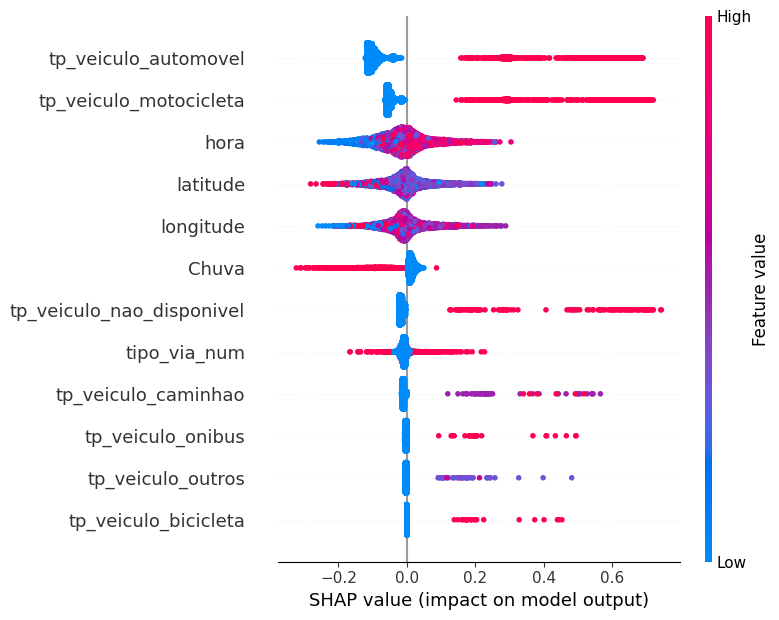

C:\Users\pirsp\AppData\Local\Temp\ipykernel_17808\1063239192.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)


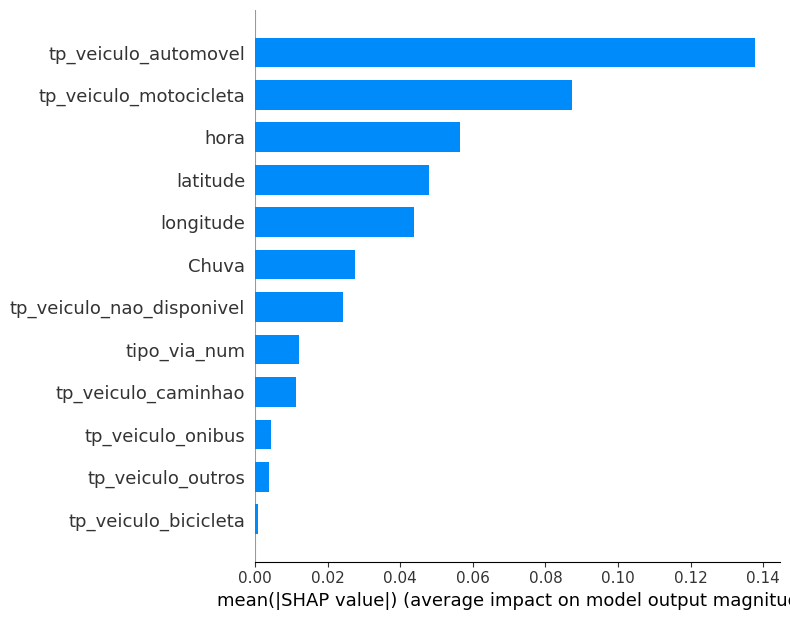

In [16]:
explainer = shap.Explainer(model.predict_proba, X_train)
shap_values = explainer(X_test)

# Gráfico de Resumo Detalhado (Beeswarm) para a classe 1
# Usamos max_display para mostrar as 15 features mais importantes
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=15, show=True)

# Gráfico de Barras (Importância Global) para a classe 1
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)